In [5]:
from pathlib import Path
import SimpleITK as sitk
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from xrayto3d_preprocess import (
    read_image,
    write_image,
    get_orientation_code_itk,
    read_dicom,
    get_segmentation_stats,
    reorient_to,
    get_barplot
)


In [2]:
base_path = "/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture"
# segmentations are stored here
seg_path = Path(
    "/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/data/segmentations"
)
# images are stored as dicom dirs in two subdirectories train_images and test_images
train_images_path = Path(
    "/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/data/train_images"
)
test_images_path = Path(
    "/mnt/SSD0/mahesh-home/xrayto3D-benchmark/2D-3D-Reconstruction-Datasets/rsna_cervical_fracture/data/test_images"
)


In [3]:
# gather subject list and path
seg_files = list(seg_path.glob("*.nii"))
seg_subjects = [s.stem for s in seg_files]

train_dicom_dirs = [f for f in train_images_path.iterdir() if f.is_dir()]
test_dicom_dirs = [f for f in test_images_path.iterdir() if f.is_dir()]
train_img_subjects = [f.name for f in train_dicom_dirs]
test_img_subjects = [f.name for f in test_dicom_dirs]
print("Train images", len(train_dicom_dirs), "Test images", len(test_dicom_dirs))

# create pairs of image segmentation pairs
img_seg_pair = []
for subject, seg_filepath in zip(seg_subjects, seg_files):
    try:
        # find the corrsponding image path
        img_index = train_img_subjects.index(subject)
        train_img_path = train_dicom_dirs[img_index]
        img_seg_pair.append((subject, train_img_path, seg_filepath))
    except ValueError as e:
        print(f"could not find {subject}")

# write paths to file
with open("subject_list.csv", "w") as f:
    f.write(f"id,subject,img_path,seg_path\n")  # write header
    # write each row
    for i, (subject, img_path, seg_path) in enumerate(img_seg_pair):
        f.write(f"rsna-{i:02d},{subject},{img_path},{seg_path}\n")

# write subject list to file
with open("rsna_cervical.list", "w") as f:
    for i, _ in enumerate(img_seg_pair):
        f.write(f"rsna-{i:02d}\n")


Train images 2019 Test images 3


In [11]:
# create subjectwise directory
subjectwise_dir = Path(base_path) / "subjectwise"
subjectwise_dir.mkdir(exist_ok=True)

# save each image segmenation pair as nifti in their own subjectwise directories
# images are in LAS, segmentations are in LPS. reorient segmentation to match that with images
for id, (subject, img_path, seg_path) in tqdm(enumerate(img_seg_pair)):
    ct = read_dicom(str(img_path))

    ct_path = Path(subjectwise_dir) / f"rsna-{id:02d}"
    ct_path.mkdir(exist_ok=True)
    write_image(ct, str(ct_path / "ct.nii.gz"))

    seg = read_image(str(seg_path))
    seg = reorient_to(seg, axcodes_to=ct)
    write_image(seg, str(ct_path / "seg.nii.gz"))


In [4]:
# get voxel count
df = pd.read_csv("subject_list.csv")
subjectwise_dir = Path(base_path) / "subjectwise"

voxels_on_border = []
num_vertebra = []
nonborder_vertebra = []
for id, subject, img_path, seg_path in df.to_numpy():
    seg = subjectwise_dir / id / "seg.nii.gz"

    stats = get_segmentation_stats(read_image(seg))
    voxels_on_border.append([stats.GetNumberOfPixelsOnBorder(l) for l in stats.GetLabels()])
    num_vertebra.append(len(stats.GetLabels()))
    nonborder_vertebra.append(
        [
            0 if stats.GetNumberOfPixelsOnBorder(l) > 0 else 1
            for l in stats.GetLabels()
        ]
    )
print(
    "Total vertebra",
    np.sum(num_vertebra),
    "Non partial Vertebra",
    np.sum([np.sum(row) for row in nonborder_vertebra]),
)

# there is at most upto C1-C7,T1-T6 vertebra
vertebra_label = [f"C{i}" if i <= 7 else f"T{i-7}" for i in range(1, 14)]
vertebra_count_dict = {label: 0 for label in vertebra_label}
for row in nonborder_vertebra:
    for exists, key in zip(row, vertebra_label):
        if exists:
            vertebra_count_dict[key] += 1
print(vertebra_count_dict)


Total vertebra 922 Non partial Vertebra 710
{'C1': 78, 'C2': 77, 'C3': 82, 'C4': 85, 'C5': 85, 'C6': 84, 'C7': 83, 'T1': 68, 'T2': 32, 'T3': 16, 'T4': 11, 'T5': 8, 'T6': 1}


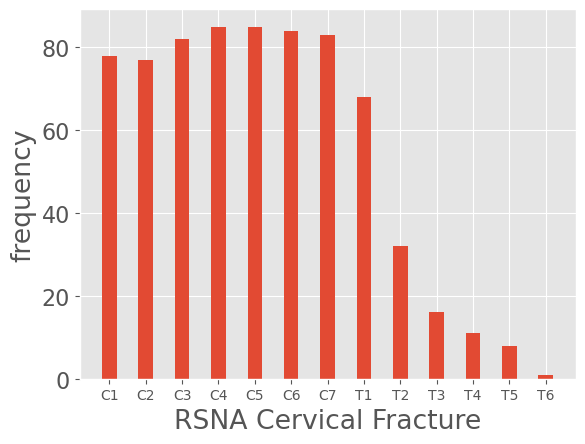

In [8]:
fig,ax = get_barplot(vertebra_count_dict)
plt.xlabel("RSNA Cervical Fracture")
plt.ylabel("frequency")
plt.savefig("rsna_stats_plot.pdf")
